With a lot of stuff from Konstantinos Barmpas' [notebook](https://github.com/KonstantinosBarmpas/Advanced-Machine-Learning-Projects/blob/master/Task%203/Task%203_AML.ipynb).

### TASK 3: HEART RHYTHM CLASSIFICATION FROM RAW ECG SIGNALS

While the previous projects dealt with medical image features, we turn now to the classification of entire time series into one of 4 classes. This time you will work with the original ECG recordings of different length sampled as 300Hz to predict heart rhythm.

In [90]:
# import libraries
import biosppy
import os
import pywt
import statistics
import scipy.stats
import sklearn.preprocessing
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [13]:
# load the data
X_train_df = pd.read_csv('./data/X_train.csv')
X_test_df = pd.read_csv('./data/X_test.csv')
y_train_df = pd.read_csv('./data/y_train.csv')

/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17979) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Preprocessing

In [109]:
# copy data
train_features = X_train_df.copy()
test_features = X_test_df.copy()
train_labels = y_train_df.copy()

# merge labels to dataframe
train_features['y'] = train_labels['y']

# drop 'id' column
train_features = train_features.drop(['id'], axis=1)
test_features = test_features.drop(['id'], axis=1)

# drop random strings
train_features = train_features.replace(r'\\n', np.nan, regex=True)
test_features = test_features.replace(r'\\n', np.nan, regex=True)

# assign label vector
train_labels = train_features['y']

# make arrays out of the dataframes
X_training = np.array(train_features)
X_testing = np.array(test_features)
y_training = np.array(train_labels)

print(X_training.shape, y_training.shape, X_testing.shape)

(5117, 17980) (5117,) (3411, 17979)


### Feature extraction

In [112]:
def load_features(data): # data of type numpy array
    #-------------------------------------------------
    # FFT, power, average and autocorrelation
    autocorr = list()
    ptp = list()
    avg = list()
    fft = list()

    for i in range(len(data)):

        h = data[i]
        h = h[~np.isnan(h)]

        h_series = pd.Series(h)
        corr = h_series.autocorr(lag=2)
        autocorr.append(corr)

        avg.append(np.average(h))
        ptp.append(np.ptp(h))

        f = np.fft.fft(h)
        array = f[0:800]
        n = 20
        indices = array.argsort()[-n:][::-1]
        fft.append(indices)

    new_autocorr = np.transpose(np.array([autocorr]))
    ptp = np.transpose(np.array([ptp]))
    avg = np.transpose(np.array([avg]))
    fft_np = np.array(fft)
    print('autocorrelation.. done')
    print('power.. done')
    print('average.. done')
    print('fourier transform.. done')
    #-------------------------------------------------
    # pad the sequences with 0
    data_pad = np.nan_to_num(data, nan=0.0)
    print('padding sequences.. done')
    #-------------------------------------------------
    # extract using biosppy
    sr = 300 

    ts_list = list()
    filtered_list = list()
    rpeaks_list = list()
    templates_ts_list = list()
    templates_list = list()
    heart_rate_ts_list = list()
    heart_rate_list = list()

    for i in range(len(data_pad)):
        sample = data_pad[i]
        ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = biosppy.signals.ecg.ecg(
            signal=sample, sampling_rate=sr, show=False)
        ts_list.append(ts)
        filtered_list.append(filtered)
        rpeaks_list.append(rpeaks)
        templates_ts_list.append(templates_ts)
        templates_list.append(templates)
        heart_rate_ts_list.append(heart_rate_ts)
        heart_rate_list.append(heart_rate)
    print('biosppy analysis.. done')
    #-------------------------------------------------
    # Normalize the data and find the average characteristic heartbeat of each patient
    normalized_templates = list()
    patients_heartbeats = list()

    for i in range(len(templates_list)):
        normalized_templates.append(sklearn.preprocessing.normalize(templates_list[i]))
        patients_heartbeats.append(sum(normalized_templates[i])/len(normalized_templates[i]))
    print('normalizing heartbeats.. done')
    #-------------------------------------------------
    # Extarct the peaks from characteristic heartbeat
    P_list = list()
    Q_list = list()
    R_list = list()
    S_list = list()
    T_list = list()

    for i in range(len(patients_heartbeats)):

        patient_current = patients_heartbeats[i]

        # Find the peak
        index = np.where(patient_current==max(patient_current))
        R = index[0]

        # First-half
        first_half = patient_current[0:R[0]]
        index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))
        Q = index[0]

        index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
        P = index[0]

        #Second half
        second_half = patient_current[R[0]+1:] 
        index = np.where(patient_current==min(second_half[0:30]))
        S = index[0]

        second_half = second_half[S[0]-R[0]+1:]
        index = np.where(patient_current==max(second_half))
        T = index[0] 

        P_list.append(P[0])
        Q_list.append(Q[0])
        R_list.append(R[0])
        S_list.append(S[0])
        T_list.append(T[0])
    print('extracting heartbeat peaks.. done')
    #-------------------------------------------------
    # Intervals and Ratios of peaks
    PR_list = list()
    QRS_list = list()
    ST_list = list()

    for i in range(len(P_list)):
        PR_list.append(R_list[i] - P_list[i])
        QRS_list.append(S_list[i] - Q_list[i])
        ST_list.append(T_list[i] - S_list[i])

    PR_list = np.array(PR_list).reshape(-1, 1)
    QRS_list = np.array(QRS_list).reshape(-1, 1)
    ST_list = np.array(ST_list).reshape(-1, 1)
    P_list = np.array(P_list).reshape(-1, 1)
    R_list = np.array(R_list).reshape(-1, 1)
    S_list = np.array(S_list).reshape(-1, 1)
    T_list = np.array(T_list).reshape(-1, 1)

    QRS_T_list = np.divide(QRS_list, T_list) 
    QRS_P_list = np.divide(QRS_list, P_list) 
    QRS_T_list = np.nan_to_num(QRS_T_list, nan=0.0, posinf=0.0, neginf=0.0)
    QRS_P_list = np.nan_to_num(QRS_P_list, nan=0.0, posinf=0.0, neginf=0.0)
    print('calculating heartbeat ratios.. done')
    #-------------------------------------------------
    # Peaks mean, median, variant, mode and standard deviation
    peaks_mean = list()
    peaks_std = list()
    peaks_median = list()
    peaks_var = list()

    for i in range(len(rpeaks_list)):
        peaks_mean.append(np.mean(rpeaks_list[i]))
        peaks_std.append(np.std(rpeaks_list[i]))
        peaks_median.append(np.median(rpeaks_list[i]))
        peaks_var.append(np.var(rpeaks_list[i]))
    print('describe peaks.. done')
    #-------------------------------------------------
    # Timings of peaks mean, median, variant and standard deviation
    ts_mean = list()
    ts_std = list()
    ts_median = list()
    ts_var = list()

    for i in range(len(ts_list)):
        d = np.diff(ts_list[i])
        ts_mean.append(np.mean(d))
        ts_std.append(np.std(d))
        ts_median.append(np.median(d))
        ts_var.append(np.mean(d) - np.var(d))

    ts_mean = np.nan_to_num(ts_mean, nan=0.0)
    ts_std = np.nan_to_num(ts_std, nan=0.0)
    ts_median = np.nan_to_num(ts_median, nan=0.0)
    ts_var = np.nan_to_num(ts_var, nan=0.0)
    print('describe peak timins.. done')
    #-------------------------------------------------
    # Range, Mean and Median of amplitudes
    max_A = list()
    min_A = list()
    mean_A = list()
    median_A = list()

    for i in range(len(patients_heartbeats)):
        patient_current = patients_heartbeats[i]
        max_A.append(max(patient_current))
        min_A.append(min(patient_current))
        mean_A.append(np.mean(patient_current))
        median_A.append(np.median(patient_current))
    print('describe amplitudes.. done')
    #-------------------------------------------------
    # Heart rates mean, median, variant and standard deviation
    hr_mean = list()
    hr_std = list()
    hr_median = list()
    hr_var = list()

    for i in range(len(heart_rate_list)):
        d = np.diff(heart_rate_list[i])
        hr_mean.append(np.mean(d))
        hr_std.append(np.std(d))
        hr_median.append(np.median(d))
        hr_var.append(np.mean(d) - np.var(d))

    hr_mean = np.nan_to_num(hr_mean, nan=0.0)
    hr_std = np.nan_to_num(hr_std, nan=0.0)
    hr_median = np.nan_to_num(hr_median, nan=0.0)
    hr_var = np.nan_to_num(hr_var, nan=0.0)
    print('describe heart rates.. done')
    #-------------------------------------------------
    # Timings of heart rates mean, median, variant and standard deviation
    hr_ts_mean = list()
    hr_ts_std = list()
    hr_ts_median = list()
    hr_ts_var = list()

    for i in range(len(heart_rate_ts_list)):
        d = np.diff(heart_rate_ts_list[i])
        hr_ts_mean.append(np.mean(d))
        hr_ts_std.append(np.std(d))
        hr_ts_median.append(np.median(d))
        hr_ts_var.append(np.mean(d) - np.var(d))

    hr_ts_mean = np.nan_to_num(hr_ts_mean, nan=0.0)
    hr_ts_std = np.nan_to_num(hr_ts_std, nan=0.0)
    hr_ts_median = np.nan_to_num(hr_ts_median, nan=0.0)
    hr_ts_var = np.nan_to_num(hr_ts_var, nan=0.0)
    print('describe heartrate timings.. done')
    #-------------------------------------------------
    # Peaks differences mean, median, variant, mode and standard deviation
    diff_mean = list()
    diff_std = list()
    diff_median = list()
    diff_var = list()
    #diff_dev = list()

    for i in range(len(rpeaks_list)):
        d = np.diff(rpeaks_list[i])
        diff_mean.append(np.mean(d))
        diff_std.append(np.std(d))
        diff_median.append(np.median(d))
        diff_var.append(np.mean(d) - np.var(d))
        #diff_dev.append(np.mean(d) - statistics.pstdev(d))

    diff_mean=np.nan_to_num(diff_mean, nan=0.0)
    diff_std=np.nan_to_num(diff_std, nan=0.0)
    diff_median=np.nan_to_num(diff_median, nan=0.0)
    diff_var=np.nan_to_num(diff_var, nan=0.0)
    #diff_dev=np.nan_to_num(diff_dev, nan=0.0)
    print('describe peaks differences.. done')
    #-------------------------------------------------
    # db2 coefficients
    cA_list = list()
    cD_list = list()

    for i in range(len(patients_heartbeats)):
        cA, cD = pywt.dwt(patients_heartbeats[i], 'db2', mode='periodic')

        cA_list.append(cA)
        cD_list.append(cD)
    print('db2 coefficients.. done')
    #-------------------------------------------------
    # Energy of the signal
    energy_list = list()

    for i in range(len(patients_heartbeats)):
        energy_list.append(np.sum(patients_heartbeats[i] ** 2))
    print('energy.. done')
    #-------------------------------------------------
    # collecting list-features
    collect_feature_lists = [P_list, Q_list, R_list, S_list, T_list, peaks_mean, peaks_std,
                             peaks_median, peaks_var, ts_mean, ts_std, ts_median, ts_var,
                             max_A, min_A, mean_A, median_A, hr_mean, hr_std, hr_median,
                             hr_var, hr_ts_mean, hr_ts_std, hr_ts_median, hr_ts_var, 
                             hr_ts_mean, hr_ts_std, hr_ts_median, hr_ts_var, diff_mean,
                             diff_std, diff_median, diff_var, energy_list, new_autocorr, 
                             ptp, avg]
    #-------------------------------------------------
    # collecting array-features
    collect_feature_arrays = [PR_list, QRS_list, ST_list, QRS_T_list, QRS_P_list, cA_list, cD_list, fft_np]
    print('collecting.. done')
    #-------------------------------------------------
    # reshape list-features into arrays and append array-features
    reshaped_features = list()
    for i in range(len(collect_feature_lists)):
        reshaped_features.append(np.array(collect_feature_lists[i]).reshape(-1, 1))

    for i in range(len(collect_feature_arrays)):
        reshaped_features.append(collect_feature_arrays[i])
    print('reshaping.. done')
    #-------------------------------------------------
    # concatenate all features
    X = np.concatenate(reshaped_features, axis=1)
    print('concatenating.. done')
    print('data shape : ', X.shape)
    print('')
    #-------------------------------------------------
    return X

In [113]:
X_train = load_features(X_training)
X_test = load_features(X_testing)

autocorrelation.. done
power.. done
average.. done
fourier transform.. done
padding sequences.. done
biosppy analysis.. done
normalizing heartbeats.. done
extracting heartbeat peaks.. done
calculating heartbeat ratios.. done


/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: divide by zero encountered in true_divide


describe peaks.. done
describe peak timins.. done
describe amplitudes.. done


/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-pa

describe heart rates.. done
describe heartrate timings.. done
describe peaks differences.. done
db2 coefficients.. done
energy.. done
collecting.. done
reshaping.. done
concatenating.. done
data shape :  (5117, 244)

autocorrelation.. done
power.. done
average.. done
fourier transform.. done
padding sequences.. done
biosppy analysis.. done
normalizing heartbeats.. done
extracting heartbeat peaks.. done


/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: divide by zero encountered in true_divide


calculating heartbeat ratios.. done
describe peaks.. done
describe peak timins.. done
describe amplitudes.. done


/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lau/opt/anaconda3/envs/latentspace/lib/python3.6/site-pa

describe heart rates.. done
describe heartrate timings.. done
describe peaks differences.. done
db2 coefficients.. done
energy.. done
collecting.. done
reshaping.. done
concatenating.. done
data shape :  (3411, 244)



### Training preparation

In [121]:
from sklearn.preprocessing import StandardScaler

In [122]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaler = scaler.transform(X_test)

### Training

In [123]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [134]:
seed = 23
estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=10,
                                       min_samples_split=40, min_samples_leaf=4, max_features='sqrt',
                                       random_state=seed)
cross_validation = cross_val_score(estimator, X_train, y_training, cv=5, n_jobs=-1, scoring='f1_micro')

In [135]:
print("f1: %0.4f (+/- %0.4f)" % (cross_validation.mean(), cross_validation.std() * 2))

f1: 0.8079 (+/- 0.0236)


### Feature importance analysis

In [97]:
training = estimator.fit(X_train, y_training)

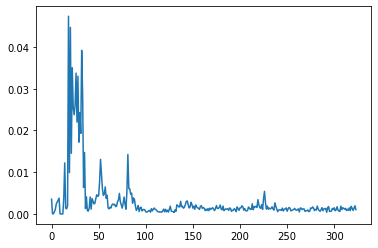

In [100]:
best_params = training.feature_importances_
plt.plot(best_params)

### Predict on test set

In [136]:
estimator.fit(X_train, y_training)

GradientBoostingClassifier(learning_rate=0.05, max_depth=10,
                           max_features='sqrt', min_samples_leaf=4,
                           min_samples_split=40, n_estimators=500,
                           random_state=23)

In [137]:
prediction = estimator.predict(X_test)

In [138]:
ID = np.array(range(len(prediction)))
df = pd.DataFrame({'id': ID,
                    'y': prediction})
name = '03_standard_scaled.csv'
path = os.path.join('.', name)
df.to_csv(path, index=False)

### Result

| F-measure (micro) | |
:- | :-
hard baseline | 0.82
public test set | 0.8147
private test set | 0.8259